In [ ]:
#default_exp vision.simclr

# SimCLR

> **SimCLR**: [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf)

> **SimCLR V2**: [Big Self-Supervised Models are Strong Semi-Supervised Learners](https://arxiv.org/pdf/2006.10029.pdf)


In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### SimCLR 

![SimCLR Framework](images/simclr.png)

SimCLR is a simple contrastive learning framework which uses 2 augmented views of the same image and InfoNCE loss for training. Different views of the same image are considered as positive examples whereas all the other images images in a batch are considered as negatives.

#### SimCLR V2

![SimCLR V2 Framework](images/simclr_v2.png)

SimCLR has a follow up paper with few minor changes and improvements. Code difference between `SimCLR` and `SimCLR V2` are minimal and there is good amount of overlap, that is why both versions are implemented here in the same module. Also, SimCLR V2 is more about the added step of knowledge distillation rather than the contrastive learning itself.

 - One difference in SimCLR V2 is that `MLP` module has 3 layers instead of 2.

 - Another difference is using a larger model for the pretraining/self supervised learning task. It is mentioned in the original paper that scaling up the model from ResNet-50 to ResNet-152 (3×+SK) gave 29% relative gain in top-1 accuracy when fine tuning with only 1% labeled data.

- Also, a few addition to data augmentation pipeline happenned, such as adding gaussian blur.

*Note that `self_supervised.augmentations` module is highly flexible, supporting all the augmentations from the popular self supervised learning algorithms by default, allowing to pass any custom augmentations and more. It should always be adjusted based on the data and problem at hand for best performance.*


> **Qote from SimCLR V2 paper:** In our experiments, we set the width of projection head’s middle layers to that of its input, so it is also adjusted by the width multiplier. However, a wider projection head improves performance even when the base network remains narrow.

SimCLR model consists of an `encoder` and a `projector (MLP)` layer. The definition of this module is fairly simple as below.

In [ ]:
#export
class SimCLRModel(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

Instead of directly using `SimCLRModel` by passing both an `encoder` and a `projector`, `create_simclr_model` function can be used by minimally passing a predefined `encoder` and the expected input channels.

In [ ]:
#export
def create_simclr_model(encoder, n_in=3, hidden_size=256, projection_size=128, nlayers=2):
    "Create SimCLR model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, nlayers=2) 
    apply_init(projector)
    return SimCLRModel(encoder, projector)

You can use `self_supervised.layers` module to create an encoder. It supports all **timm** and **fastai** models available out of the box.

We define number of input channels with `n_in`, projector/mlp's hidden size with `hidden_size`,  projector/mlp's final projection size with `projection_size` and projector/mlp's number of layers with `nlayers`.

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_simclr_model(encoder, n_in=3, hidden_size=2048, projection_size=128, nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## SimCLR Callback

The following parameters can be passed;

- **size** for random resized cropping
- **aug_func** augmentation pipeline function to be used from `self_supervised.augmentations` module
- **aug_kwargs** for any keyword arguments to be passed to `aug_func`
- **temp** temperature scaling for cross entropy loss (defaults to paper's best value)

In [ ]:
#export
class SimCLR(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, temp=0.07, print_augs=False, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        self.temp = temp
        if print_augs: print(self.aug1), print(self.aug2)
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
    
    
    def _remove_diag(self, x):
        bs = x.shape[0]
        return x[~torch.eye(bs).bool()].reshape(bs,bs-1)    
    
    
    def lf(self, pred, *yb):
        pred, targ = F.normalize(pred, dim=1), yb[0]
        sim = self._remove_diag(pred @ pred.T) / self.temp
        targ = self._remove_diag(torch.eye(targ.shape[0], device=self.dls.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(sim, targ)
    
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

`DistributedSimCLR` is a distributed implementation of InfoNCE Loss. It effectively increases the number of negative samples to all available samples across all GPUs during loss calculation. For example, if you use batch size of 16 per GPU and 8 GPUs, then the loss will be calculated using a similarity matrix with size of 16x8 x 16x8 = 1024x1024. In literature/experiments it's mentioned that more negatives help training.

Following callback should be used together with `DistributedDataParallel` and inside a python script which will be executed in launch mode, such as:

> **python -m fastai.launch script.py --FOLD 4 --size 640 --bs 12 --epochs 10 --lr 1e-3 --arch_name tf_efficientnet_b7_ns**

For more details about distributed operations like `all gather`, see https://pytorch.org/tutorials/intermediate/dist_tuto.html.

> **Training Tip:** You can maximize your effective batchsize by using gradient checkpointing (see self_supervised.layers module), fp16 (to_fp16() in fastai) and distributed callback. Don't worry if you only have access to a single GPU, usually just using gradient checkpointing and fp16 is enough to increase your batch size to 256 and beyond. Which is enough to train highly competitive models.

In [ ]:
#export
from self_supervised.dist import GatherLayer

class DistributedSimCLR(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, temp=0.07, print_augs=False, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        self.temp = temp
        if print_augs: print(self.aug1), print(self.aug2)
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
    
    
    def _remove_diag(self, x):
        bs = x.shape[0]
        return x[~torch.eye(bs).bool()].reshape(bs,bs-1)    
    
    
    def lf(self, pred, *yb):
        # collect all embeddings from other GPUs
        all_preds = list(GatherLayer.apply(pred))
        # put current rank embeddings to index 0 for loss calc
        all_preds.pop(rank_distrib())
        all_preds = torch.cat([pred]+all_preds)
        
        pred, all_preds, targ = F.normalize(pred, dim=1), F.normalize(all_preds, dim=1), yb[0]
        sim = self._remove_diag(pred @ all_preds.T) / self.temp
        targ = self._remove_diag(torch.eye(targ.shape[0], device=self.dls.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(sim, targ)
    
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_simclr_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model, cbs=[SimCLR(size=28, aug_func=get_batch_augs,
                            rotate=False, jitter=False, bw=False, blur=False,
                            stats=None, cuda=False),
                     ShortEpochCallback(0.001)])

Also, with `show_one()` method you can inspect data augmentations as a sanity check. You can use existing augmentation functions from `augmentations` module.

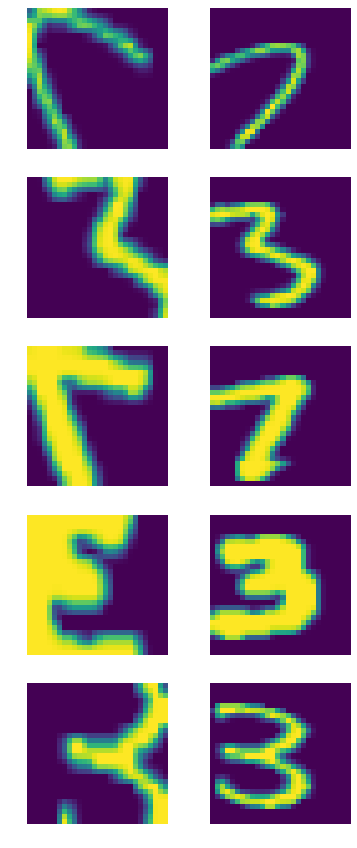

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(3.6092)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
